In [1]:
%reload_ext autoreload
%autoreload 1
%autosave 1

Autosaving every 1 seconds


# Импорт библиотек

In [2]:
import os
import random
from collections import defaultdict
from itertools import product

import numpy as np
from PIL import Image

# Определение стилей

In [3]:
styles = {
    'прическа':[
        'нет волос',
        'длинные в пучок',
        'длинные волнистые',
        'длинные прямые',
        'короткая волнистые',
        'короткая прямые',
        'короткая курчавые'
    ],
    'цвет волос':[
        'черный',
        'блонд',
        'каштановый',
        'пастельный розовый',
        'рыжий',
        'серебристо серый',
    ],
    'аксесуар':[
        'нет очков',
        'круглые очки',
        'солнцезащитные очки',
    ],
    'одежда':[
        'худи',
        'комбинезон',
        'футболка с круглым вырезом',
        'футболка с V-вырезом',
    ],
    'цвет одежды':[
        'черный',
        'синий',
        'серый',
        'зеленый',
        'оранжевый',
        'розовый',
        'красный',
        'белый'
    ],
}

styles_count = {
    'прическа':[
        7,
        0,
        1,
        23,
        1,
        11,
        7
    ],
    'цвет волос':[
        7,
        6,
        2,
        3,
        8,
        24,
    ],
    'аксесуар':[
        11,
        22,
        17,
    ],
    'одежда':[
        7,
        18,
        19,
        6,
    ],
    'цвет одежды':[
        4,
        5,
        6,
        8,
        6,
        8,
        7,
        6
    ],
}

# Styles Generator

In [4]:
class StylesGenerator:
    def __init__(
        self,
        styles: dict[str, list],
        styles_count: dict[str, list]
    ) -> None:
        self._all_possible_styles = list(product(*styles.values()))
        self._styles_weights = self._calculate_weights(styles, styles_count)

    def _calculate_weights(self, styles, styles_count):
        styles_probabilities = self._calculate_probabilities(styles, styles_count)
        weights = []
        for style in self._all_possible_styles:
            style_prob = 1
            for style_name, style_component in zip(style, styles.keys()):
                style_prob *= styles_probabilities[style_component][style_name]
            weights.append(style_prob)
        return weights

    def _calculate_probabilities(self, styles, styles_count):
        probabilities = defaultdict(dict)
        for style_component, available_styles in styles.items():
            for style_index, style_name in enumerate(available_styles):
                probabilities[style_component][style_name] = (
                    (styles_count[style_component][style_index] + 1) / 
                    (sum(styles_count[style_component]) + len(styles_count[style_component]))
                )
        return probabilities

    def __iter__(self):
        return self

    def __next__(self):
        generated_style = random.choices(
            self._all_possible_styles,
            self._styles_weights,
            k=1
        )[0]
        return generated_style, self._styles_weights[self._all_possible_styles.index(generated_style)]

In [5]:
sg = StylesGenerator(styles, styles_count)

Выведем несколько примеров генерации

In [6]:
next(sg)

(('длинные прямые',
  'серебристо серый',
  'солнцезащитные очки',
  'комбинезон',
  'зеленый'),
 0.0034854540384794126)

In [7]:
next(sg)

(('длинные прямые', 'рыжий', 'круглые очки', 'худи', 'красный'),
 0.0006000688122387947)

In [8]:
next(sg)

(('нет волос', 'рыжий', 'круглые очки', 'комбинезон', 'белый'),
 0.00041567266681124843)

In [9]:
next(sg)

(('нет волос',
  'рыжий',
  'солнцезащитные очки',
  'футболка с V-вырезом',
  'серый'),
 0.00011985070027052013)

In [10]:
next(sg)

(('короткая прямые',
  'каштановый',
  'солнцезащитные очки',
  'футболка с круглым вырезом',
  'оранжевый'),
 0.00017121528610074304)

# Avatars generation

In [11]:
class AvatarGenerator:
    avatar_size = (560, 528)

    def __init__(self, avatar_paths):
        self._avatars = self._load_avatars(avatar_paths)
        self._pixel_distributions = self._calculate_pixel_distributions()

    def __iter__(self):
        return self

    def _load_avatars(self, avatar_paths):
        avatars = []
        for path in avatar_paths:
            avatar = np.array(Image.open(path))
            avatars.append(avatar)
        return avatars

    def _calculate_pixel_distributions(self):
        num_avatars = len(self._avatars)
        pixel_distributions = {
            'red': np.zeros((self.avatar_size[0], self.avatar_size[1], 256)),
            'green': np.zeros((self.avatar_size[0], self.avatar_size[1], 256)),
            'blue': np.zeros((self.avatar_size[0], self.avatar_size[1], 256))
        }
        for avatar in self._avatars:
            for i in range(self.avatar_size[0]):
                for j in range(self.avatar_size[1]):
                    pixel_distributions['red'][i, j, avatar[i, j, 0]] += 1
                    pixel_distributions['green'][i, j, avatar[i, j, 1]] += 1
                    pixel_distributions['blue'][i, j, avatar[i, j, 2]] += 1
        
        # Normalize distributions
        for channel in pixel_distributions:
            pixel_distributions[channel] /= num_avatars

        return pixel_distributions

    def __next__(self):
        avatar = np.zeros((self.avatar_size[0], self.avatar_size[1], 3), dtype=np.uint8)
        for i in range(self.avatar_size[0]):
            for j in range(self.avatar_size[1]):
                red_value = np.random.choice(256, p=self._pixel_distributions['red'][i][j])
                green_value = np.random.choice(256, p=self._pixel_distributions['green'][i][j])
                blue_value = np.random.choice(256, p=self._pixel_distributions['blue'][i][j])
                avatar[i][j] = [red_value, green_value, blue_value]
        return Image.fromarray(avatar)

In [12]:
avatar_dir = os.path.join(os.pardir, "avatars")
avatar_files = os.listdir(avatar_dir)
avatar_paths = [f"{avatar_dir}/{file}" for file in avatar_files]

In [13]:
avatar_generator = AvatarGenerator(avatar_paths)

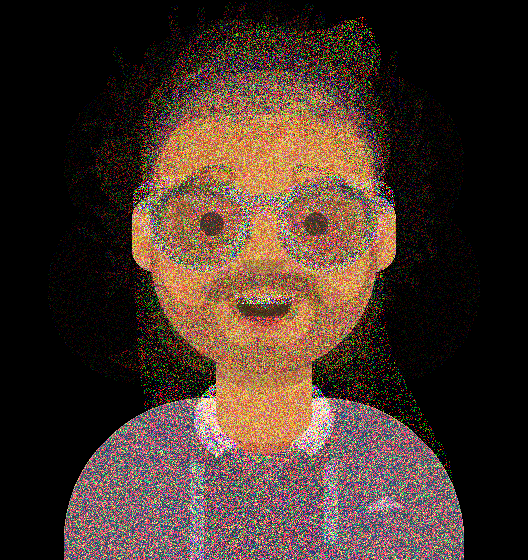

In [14]:
generated_avatar = next(avatar_generator)
generated_avatar.show()

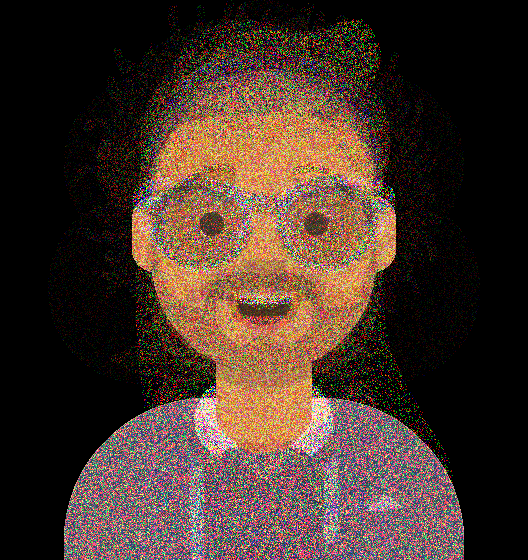

In [15]:
generated_avatar = next(avatar_generator)
generated_avatar.show()

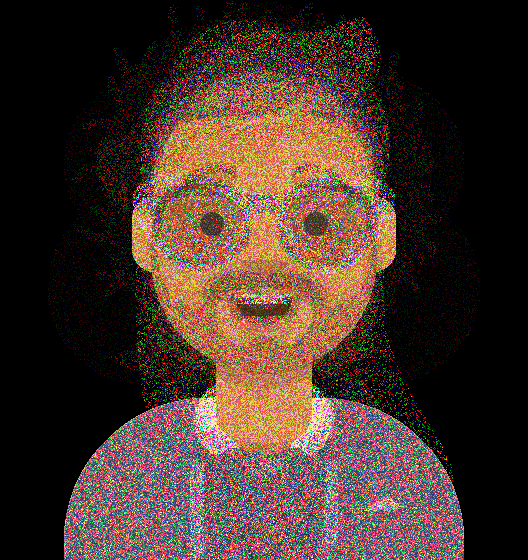

In [16]:
generated_avatar = next(avatar_generator)
generated_avatar.show()